# <center> [Working with World Development Indicators (WDI)](https://datatopics.worldbank.org/world-development-indicators/)</center>

<center><a href="https://data.worldbank.org/indicator"> <img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wb-header-en.svg" alt="WDI" width=300/></a>  </center>

* World Development Indicators (WDI) is the World Bank’s premier compilation of cross-country comparable data on development.
* Widely used for analysis
* Free and easy to access
* Lot's of variables are available, from multiple sources that have been collected by the WB. 
* If you check [their website](https://data.worldbank.org/) you can see more information on them, also identify and search the variables you may want to focus on. 

# Setup

# Import Modules and set Paths

In [14]:
# Basic Packages
from __future__ import division
import os
from datetime import datetime

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%pylab --no-import-all
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

import plotly.express as px
import plotly.graph_objects as go

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# Next line can import all of plotnine, but may overwrite things? Better import each function/object you need
#from plotnine import *

# Data
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# Data Munging
from itertools import product, combinations
import difflib
import pycountry
import geocoder
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso3')
mapper2 = country(from_key='iso3', to_key='iso')
mapper3 = country(from_key='iso3', to_key='name')

# Regressions
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

Using matplotlib backend: module://ipympl.backend_nbagg
Populating the interactive namespace from numpy and matplotlib


In [2]:
currentYear = datetime.now().year
year = min(2020, currentYear-2)

# Getting WDI data from the World Bank

* [Head over to the WDI Indicator website](https://data.worldbank.org/indicator) 
* Search for the variable you are interested in

    (e.g., **GDP per capita, PPP (constant 2017 international $)**)
* The link will become [https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD)

    (if feasible it will display a figure)

In [3]:
# Import display options for showing websites
from IPython.display import IFrame

url = 'https://data.worldbank.org/share/widget?indicators=NY.GDP.PCAP.PP.KD'
IFrame(url, width=500, height=300)

## Downloading the data
* Suboptimal: Download from the website 

    (Not best approach, since you need to do it for every variable every time data is updated)

* Using API: Let's instead use the wonderful [pandas-data-reader package](https://pandas-datareader.readthedocs.io/en/latest/index.html)

# <center><font size="30">WDI with</font> </center>
# <center> <a href="https://pandas-datareader.readthedocs.io/en/latest/index.html"><img src="https://pandas-datareader.readthedocs.io/en/latest/_static/pandas-datareader-plain.svg" alt="pandas-data-reader" width=300/></a></center>

In [4]:
url = 'https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-wb'
IFrame(url, width=800, height=400)

## Steps

1. Import **pandas-data-reader**
```python
from pandas_datareader import data, wb
```
2. Download basic country/aggregates information
```python
wbcountries = wb.get_countries()
```
3. Clean up
```python
# If you want to keep aggregate data for regions or world comment out next line
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'
```

In [5]:
wbcountries = wb.get_countries()
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'

4. Get Indicators of interest

* Few and varied indicators of interest: 
    
    Search for the variable on the WDI Indicator website (as explained above)
        
    (e.g., [https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD))
        
    Add the indicator's name into a list of indicators in **Python**

    (i.e., everything that comes after **https://data.worldbank.org/indicator/**. E.g. `NY.GDP.PCAP.PP.KD`)
        
    ```python
    wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']
    ```

In [6]:
wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']

* Many related indicators or mass search

    (e.g., search for all variables containing the word population)

    ```python
    popvars = wb.search(string='population')
    ```
    
    This returns a dataframe, where the column `id` has the IDs for the indicators

In [7]:
popvars = wb.search(string='population')
popvars.head()

,id,name,unit,source,sourceNote,sourceOrganization,topics
24,1.1_ACCESS.ELECTRICITY.TOT,Access to electricity (% of total population),,Sustainable Energy for All,Access to electricity is the percentage of pop...,b'World Bank Global Electrification Database 2...,
39,1.2_ACCESS.ELECTRICITY.RURAL,Access to electricity (% of rural population),,Sustainable Energy for All,Access to electricity is the percentage of rur...,b'World Bank Global Electrification Database 2...,
40,1.3_ACCESS.ELECTRICITY.URBAN,Access to electricity (% of urban population),,Sustainable Energy for All,Access to electricity is the percentage of tot...,b'World Bank Global Electrification Database 2...,
164,2.1_ACCESS.CFT.TOT,Access to Clean Fuels and Technologies for coo...,,Sustainable Energy for All,,b'',
195,3.11.01.01.popcen,Population census,,Statistical Capacity Indicators,"Population censuses collect data on the size, ...",b'World Bank Microdata library. Original sourc...,


5. Download data for selected indicators, years, and countries

```python
wdi = wb.download(indicator=wdi_indicators, country=list_of_countries_ISO_A2_codes, start=start_year, end=end_year)
```

6. Clean up and process data
```python
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
```

In [8]:
wdi = wb.download(indicator=wdi_indicators, country=wbcountries.iso2c.values, start=1950, end=year)
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
wdi['ln_gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD'].apply(np.log)
wdi['ln_pop'] = wdi['SP.POP.TOTL'].apply(np.log)
wdi.head()

/Users/ozak/anaconda3/envs/GeoPython39env/lib/python3.9/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: JG, XK


,country,year,NY.GDP.PCAP.PP.KD,NY.GDP.PCAP.KD,SL.GDP.PCAP.EM.KD,SP.POP.GROW,SP.POP.TOTL,SP.DYN.WFRT,SP.DYN.TFRT.IN,ln_gdp_pc,ln_pop
0,Aruba,2020,29563.756955,23026.332866,NaN,0.428017,106766.0,NaN,1.901,10.294304,11.578395
1,Aruba,2019,38221.117314,29769.293907,NaN,0.437415,106310.0,NaN,1.901,10.551143,11.574115
2,Aruba,2018,39206.356147,30536.667193,NaN,0.459266,105846.0,NaN,1.896,10.576594,11.569740
3,Aruba,2017,38893.960556,30293.351539,NaN,0.471874,105361.0,NaN,1.886,10.568594,11.565148
4,Aruba,2016,37046.877414,28854.713299,NaN,0.502860,104865.0,NaN,1.872,10.519939,11.560429


7. Add other WB data from the ``wbcountries`` dataframe
```python
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
```

In [9]:
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
wdi.head()

,iso3c,iso2c,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude,...,year,NY.GDP.PCAP.PP.KD,NY.GDP.PCAP.KD,SL.GDP.PCAP.EM.KD,SP.POP.GROW,SP.POP.TOTL,SP.DYN.WFRT,SP.DYN.TFRT.IN,ln_gdp_pc,ln_pop
0,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,2020,29563.756955,23026.332866,NaN,0.428017,106766.0,NaN,1.901,10.294304,11.578395
1,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,2019,38221.117314,29769.293907,NaN,0.437415,106310.0,NaN,1.901,10.551143,11.574115
2,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,2018,39206.356147,30536.667193,NaN,0.459266,105846.0,NaN,1.896,10.576594,11.569740
3,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,2017,38893.960556,30293.351539,NaN,0.471874,105361.0,NaN,1.886,10.568594,11.565148
4,ABW,AW,Aruba,Latin America & Caribbean,,High Income,Not classified,Oranjestad,-70.0167,12.5167,...,2016,37046.877414,28854.713299,NaN,0.502860,104865.0,NaN,1.872,10.519939,11.560429


# Plotting WDI data

## Many options
* Since the data is a **pandas** dataframe, we could just use its functions as [we did previously](./Intro-Data-Analysis-Pandas.ipynb)
* Use the **[seaborn](https://seaborn.pydata.org/index.html)** package
* Use the **[plotly](https://plotly.com/python/)** package
* Use the **[plotnine](https://plotnine.readthedocs.io/en/stable/)** package

# Plots with 
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=300/></a></center>

In [10]:
url = 'https://seaborn.pydata.org/examples/index.html'
IFrame(url, width=800, height=400)

Let's create a [Scatterplot with varying point sizes and hues](https://seaborn.pydata.org/examples/scatter_bubbles.html) that plots the latitude and Log[GDP per capita] of each country and uses its log-population and the WB region in the last available year as the size and hue.

In [102]:
dffig = wdi.loc[wdi.year==year].dropna(subset=['ln_gdp_pc', 'latitude', 'ln_pop']).sort_values(by='region').reset_index()

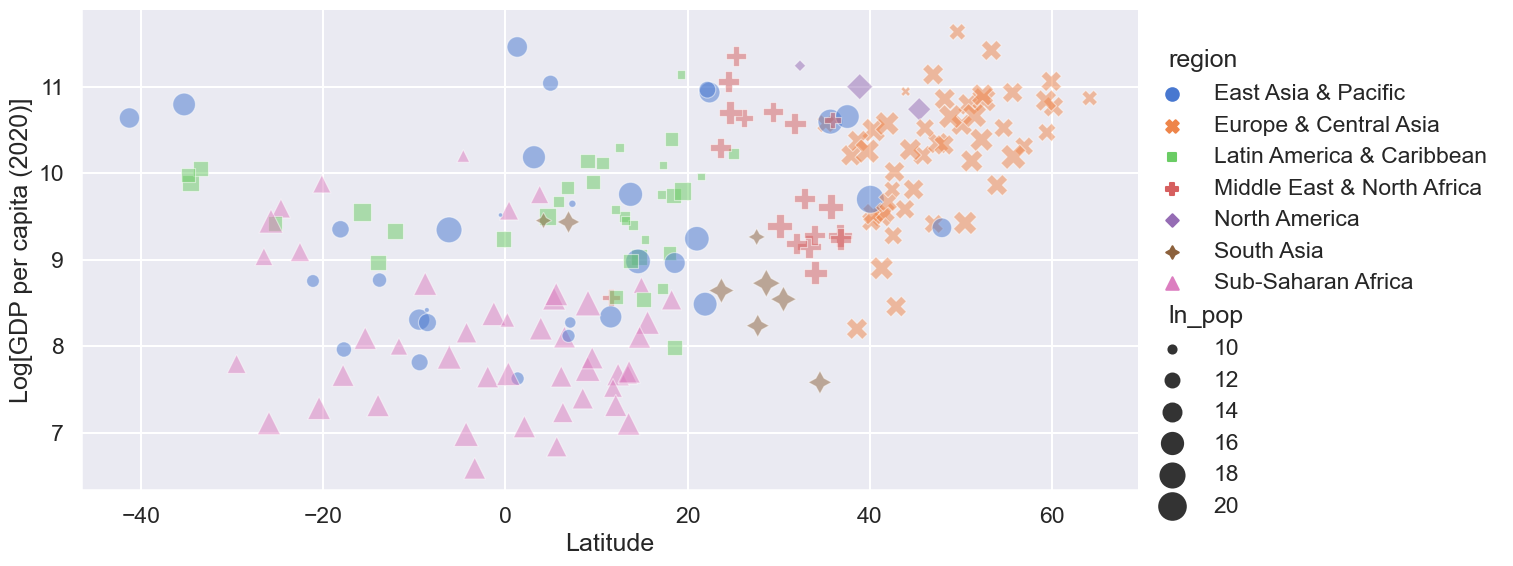

In [82]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

g = sns.relplot(x="latitude", 
            y="ln_gdp_pc", 
            data=dffig,
            hue="region",
            hue_order = wdi.region.drop_duplicates().sort_values(),
            style="region",
            style_order = wdi.region.drop_duplicates().sort_values(),
            size="ln_pop",
            sizes=(10, 400), 
            alpha=.5, 
            height=6,
            aspect=2,
            palette="muted",
           )
g.set_axis_labels('Latitude', 'Log[GDP per capita (' + str(year) + ')]')

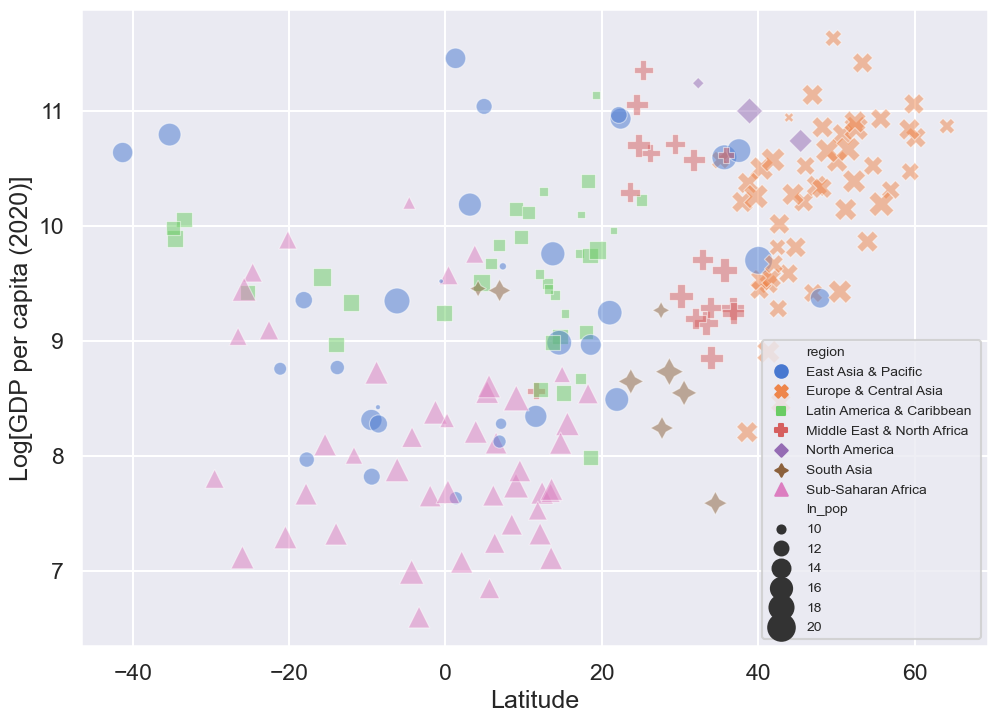

In [83]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

fig, ax = plt.subplots()
sns.scatterplot(x="latitude", 
                y="ln_gdp_pc", 
                data=dffig,
                hue="region",
                hue_order = wdi.region.drop_duplicates().sort_values(),
                style="region",
                style_order = wdi.region.drop_duplicates().sort_values(),
                size="ln_pop",
                sizes=(10, 400), 
                alpha=.5, 
                palette="muted",
                ax=ax
               )
ax.set_xlabel('Latitude')
ax.set_ylabel('Log[GDP per capita (' + str(year) + ')]')
ax.legend(fontsize=10)

# Based on **seaborn** we can create a useful functions that create plots for us
## E.g., scatter plots with labels, OLS regression lines, 45 degree lines, etc

In [45]:
def my_xy_plot(dfin, 
               x='SP.POP.GROW', 
               y='ln_gdp_pc', 
               labelvar='iso3c', 
               dx=0.006125, 
               dy=0.006125, 
               xlogscale=False, 
               ylogscale=False,
               xlabel='Growth Rate of Population', 
               ylabel='Log[Income per capita in ' +  str(year) + ']',
               labels=False,
               xpct = False,
               ypct = False,
               OLS=False,
               OLSlinelabel='OLS',
               ssline=False,
               sslinelabel='45 Degree Line',
               filename='income-pop-growth.pdf',
               hue='region',
               hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                          'Latin America & Caribbean ', 'Middle East & North Africa',
                          'North America', 'South Asia', 'Sub-Saharan Africa '],
               style='incomeLevel', 
               style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
               palette=None,
               size=None,
               sizes=None,
               fontsize=10,
               save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    #hue='incomeLevel',
                    #hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    #hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                    #           'Latin America & Caribbean ', 'Middle East & North Africa',
                    #           'North America', 'South Asia', 'Sub-Saharan Africa '],
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                    size=size,
                    sizes=sizes,
                    #palette=sns.color_palette("Blues_r", df[hue].unique().shape[0]+6)[:df[hue].unique().shape[0]*2:2],
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=12, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!=hue) & (labels!=style) & (labels!=size)])
    labels = list(labels[(labels!=hue) & (labels!=style) & (labels!=size)])
    ax.legend(handles=handles, labels=labels, fontsize=fontsize)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    pass

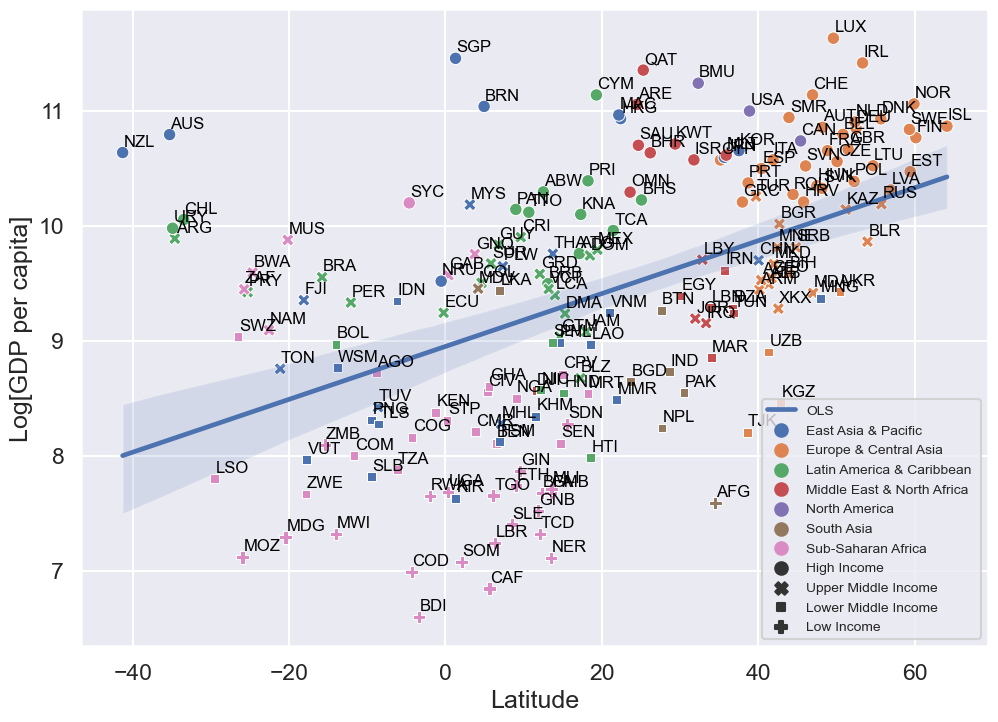

In [84]:
my_xy_plot(dffig, 
           x='latitude', 
           y='ln_gdp_pc', 
           xlabel='Latitude', 
           ylabel='Log[GDP per capita]', 
           OLS=True, 
           labels=True, 
           #size="ln_pop",
           #sizes=(10, 400), 
           filename='ln-gdp-pc-latitude.pdf')

# Plots with 
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="seaborn" width=300/></a></center>

In [52]:
url = 'https://plotly.com/python/'
IFrame(url, width=800, height=400)

## Let's [select symbols to plot](https://plotly.com/python/marker-style/) so it looks like the previous ones and also to improve visibility

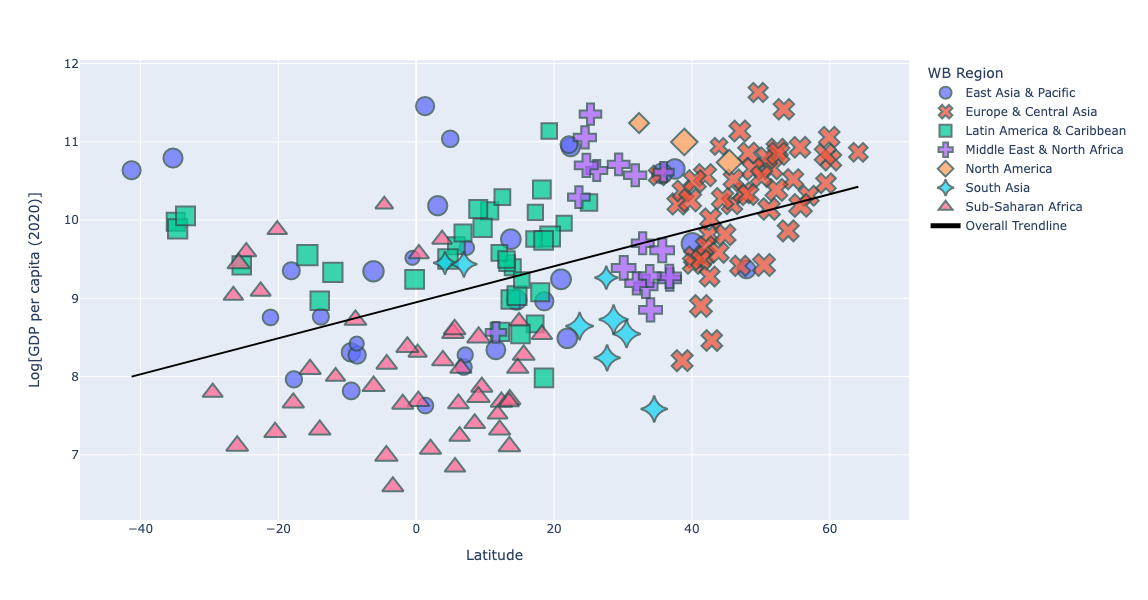

In [105]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig = px.scatter(dffig,
                 x="latitude", 
                 y="ln_gdp_pc", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pop'],
                 size='ln_pop',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "latitude": "Latitude",
                     "ln_gdp_pc": "Log[GDP per capita (" + str(year) + ")]",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=600,
                )
fig.update_traces(marker=dict(#size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

## We can access the results of the regression in **plotly express**

In [107]:
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     57.42
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           1.55e-12
Time:                        14:19:43   Log-Likelihood:                -270.26
No. Observations:                 190   AIC:                             544.5
Df Residuals:                     188   BIC:                             551.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9496      0.092     97.348      0.000       8.768       9.131
x1             0.0230      0.003      7.578      0.000       0.017       0.029
==============================================================================
Omnibus:                        0.797   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.671   Jarque-Bera (JB):                0.853
Skew:                           0.002   Prob(JB):                        0.653
Kurtosis:                       2.672   Cond. No.                         38.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Quick and Easy Maps